<a href="https://colab.research.google.com/github/Lee-Gunju/AI-paper-code-review-for-personal-project/blob/master/Supervised_Contrastive_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install tensorflow-addons


     |████████████████████████████████| 706kB 7.3MB/s 


In [ ]:
import tensorflow as tf
import tensorflow_addons as tfa
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt


In [ ]:
num_classes = 10
input_shape = (32, 32, 3)

# Load the train and test data splits
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

# Display shapes of train and test datasets
print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")

170500096/170498071 [==============================] - 5s 0us/step
x_train shape: (50000, 32, 32, 3) - y_train shape: (50000, 1)
x_test shape: (10000, 32, 32, 3) - y_test shape: (10000, 1)


In [ ]:
data_augmentation = keras.Sequential([
                                      layers.experimental.preprocessing.Normalization(),
                                      layers.experimental.preprocessing.RandomFlip("horizontal"),
                                      layers.experimental.preprocessing.RandomRotation(0.02),
                                      layers.experimental.preprocessing.RandomWidth(0.2),
                                      layers.experimental.preprocessing.RandomHeight(0.2)
])

# Setting the state of the normalization layer.
data_augmentation.layers[0].adapt(x_train)

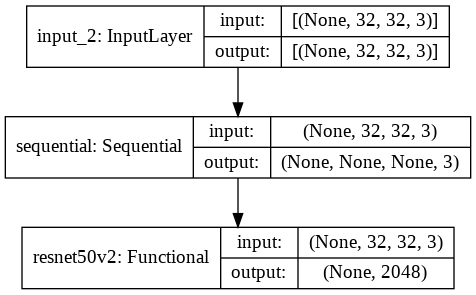

In [ ]:
def create_encoder():
  resnet = keras.applications.ResNet50V2(include_top=False, weights=None, input_shape=input_shape, pooling='avg')
  inputs = keras.Input(shape = input_shape)
  augmented = data_augmentation(inputs)
  outputs = resnet(augmented)
  model = keras.Model(inputs = inputs, outputs = outputs, name = "cifar10-encoder")
  return model

encoder = create_encoder()
keras.utils.plot_model(encoder, show_shapes=True)


In [ ]:
learning_rate = 0.001
batch_size = 265
hidden_units = 512
projection_units = 128
num_epochs = 50
dropout_rate = 0.5
temperature = 0.05

In [ ]:
def create_classifier(encoder, trainable = True):
  for i in encoder.layers:
    i.trainable = trainable

  inputs = keras.Input(shape= input_shape)
  features = encoder(inputs)
  features = layers.Dropout(dropout_rate)(features)
  features = layers.Dense(hidden_units, activation='relu')(features)
  features = layers.Dropout(dropout_rate)(features)
  outputs = layers.Dense(num_classes, activation='softmax')(features)

  model = keras.Model(inputs = inputs, outputs = outputs, name = "cifar10-classifier")
  model.compile(optimizer = keras.optimizers.Adam(learning_rate=learning_rate),
                loss = keras.losses.SparseCategoricalCrossentropy(),
                metrics = [keras.metrics.SparseTopKCategoricalAccuracy()])
  
  return model 


In [ ]:
encoder = create_encoder()
classifier = create_classifier(encoder)
keras.utils.plot_model(classifier, show_shapes=True)

history = classifier.fit(x = x_train, y = y_train, batch_size = batch_size, epochs= num_epochs)

accuracy = classifier.evaluate(x_test, y_test)
print(f"Test accuracy: {round(accuracy * 100, 2)}%")


Epoch 1/50
189/189 [==============================] - 94s 279ms/step - loss: 2.2262 - sparse_top_k_categorical_accuracy: 0.7059
Epoch 2/50
189/189 [==============================] - 31s 165ms/step - loss: 1.5742 - sparse_top_k_categorical_accuracy: 0.9034
Epoch 3/50
189/189 [==============================] - 29s 155ms/step - loss: 1.3957 - sparse_top_k_categorical_accuracy: 0.9316
Epoch 4/50
189/189 [==============================] - 24s 128ms/step - loss: 1.2542 - sparse_top_k_categorical_accuracy: 0.9463
Epoch 5/50
189/189 [==============================] - 25s 132ms/step - loss: 1.1626 - sparse_top_k_categorical_accuracy: 0.9545
Epoch 6/50
189/189 [==============================] - 28s 149ms/step - loss: 1.0936 - sparse_top_k_categorical_accuracy: 0.9605
Epoch 7/50
189/189 [==============================] - 25s 134ms/step - loss: 1.0152 - sparse_top_k_categorical_accuracy: 0.9651
Epoch 8/50
189/189 [==============================] - 25s 133ms/step - loss: 0.9607 - sparse_top_k_categ

TypeError: ignored

In [ ]:
class SupervisedContrastiveLoss(keras.losses.Loss):
  def __init__(self, temperature = 1, name= None):
    super(SupervisedContrastiveLoss, self).__init__(name = name)
    self.temperature = temperature

  def call(self, labels, feature_vectors, sample_weight = None):
    # Normalize feature vectors
    feature_vectors_normalized = tf.math.l2_normalize(feature_vectors, axis= 1)
    # Compute logits
    logits = tf.divide(tf.matmul(feature_vectors_normalized, tf.transpose(feature_vectors_normalized)),
                       self.temperature)
    return tfa.losses.npairs_loss(tf.squeeze(labels), logits)


def add_projection_head(encoder):
  inputs = keras.Input(shape = input_shape)
  features = encoder(inputs)
  outputs = layers.Dense(projection_units, activation = 'relu')(features)
  model = keras.Model(inputs = inputs, outputs = outputs, name = "cifar-encoder_with_projection-head")
  return model
  
   




In [ ]:
encoder = create_encoder()

encoder_with_projection_head = add_projection_head(encoder)
encoder_with_projection_head.compile(
    optimizer = keras.optimizers.Adam(learning_rate),
    loss=SupervisedContrastiveLoss(temperature)
)

encoder_with_projection_head.summary()

history = encoder_with_projection_head.fit(
    x=x_train, y=y_train, batch_size=batch_size, epochs=num_epochs
)

Model: "cifar-encoder_with_projection-head"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        [(None, 32, 32, 3)]       0         
_________________________________________________________________
cifar10-encoder (Functional) (None, 2048)              23564807  
_________________________________________________________________
dense_3 (Dense)              (None, 128)               262272    
Total params: 23,827,079
Trainable params: 23,781,632
Non-trainable params: 45,447
_________________________________________________________________
Epoch 1/50
189/189 [==============================] - 28s 124ms/step - loss: 5.5497
Epoch 2/50
189/189 [==============================] - 24s 126ms/step - loss: 5.1852
Epoch 3/50
189/189 [==============================] - 25s 130ms/step - loss: 5.0619
Epoch 4/50
189/189 [==============================] - 25s 135ms/step - loss: 4.9542
Epoch 5/5

In [ ]:
classifier = create_classifier(encoder, trainable=False)

history = classifier.fit(x=x_train, y=y_train, batch_size=batch_size, epochs=num_epochs)

accuracy = classifier.evaluate(x_test, y_test)[1]
print(f"Test accuracy: {round(accuracy * 100, 2)}%")

Epoch 1/50
189/189 [==============================] - 10s 37ms/step - loss: 0.4750 - sparse_top_k_categorical_accuracy: 0.9794
Epoch 2/50
189/189 [==============================] - 7s 36ms/step - loss: 0.3122 - sparse_top_k_categorical_accuracy: 0.9963
Epoch 3/50
189/189 [==============================] - 7s 37ms/step - loss: 0.3013 - sparse_top_k_categorical_accuracy: 0.9969
Epoch 4/50
189/189 [==============================] - 7s 36ms/step - loss: 0.2955 - sparse_top_k_categorical_accuracy: 0.9962
Epoch 5/50
189/189 [==============================] - 7s 37ms/step - loss: 0.2875 - sparse_top_k_categorical_accuracy: 0.9975
Epoch 6/50
189/189 [==============================] - 7s 37ms/step - loss: 0.3028 - sparse_top_k_categorical_accuracy: 0.9973
Epoch 7/50
189/189 [==============================] - 7s 37ms/step - loss: 0.2856 - sparse_top_k_categorical_accuracy: 0.9969
Epoch 8/50
189/189 [==============================] - 7s 36ms/step - loss: 0.2943 - sparse_top_k_categorical_accuracy